# Semi-supervised AQI Classification — Self-Training

- Mục tiêu: chạy self-training để **tăng lượng nhãn** cho AQI khi thiếu nhãn.
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: sweep TAU / LABEL_MISSING_FRACTION và so sánh với baseline supervised.

In [1]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.90
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/metrics_self_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_self_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_self_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"


>> Running TAU=0.9
   Iter 1: Acc=0.7481 | F1=0.6147 | Added=1000
   Iter 2: Acc=0.7505 | F1=0.6235 | Added=1000
   Iter 3: Acc=0.7513 | F1=0.6248 | Added=1000
   Iter 4: Acc=0.7473 | F1=0.6202 | Added=1000
   Iter 5: Acc=0.7482 | F1=0.6179 | Added=1000
   Iter 6: Acc=0.7474 | F1=0.6222 | Added=1000
   Iter 7: Acc=0.7522 | F1=0.6318 | Added=1000
   Iter 8: Acc=0.7456 | F1=0.6161 | Added=1000
   Iter 9: Acc=0.7534 | F1=0.6268 | Added=1000
   Iter 10: Acc=0.7539 | F1=0.6314 | Added=1000
   Iter 11: Acc=0.7471 | F1=0.6234 | Added=1000
   Iter 12: Acc=0.7434 | F1=0.6187 | Added=1000
   Iter 13: Acc=0.7499 | F1=0.6307 | Added=1000
   Iter 14: Acc=0.7424 | F1=0.6142 | Added=1000
   Iter 15: Acc=0.7472 | F1=0.6202 | Added=1000

Final model (TAU=0.9): Accuracy=0.7472, Macro F1=0.6202


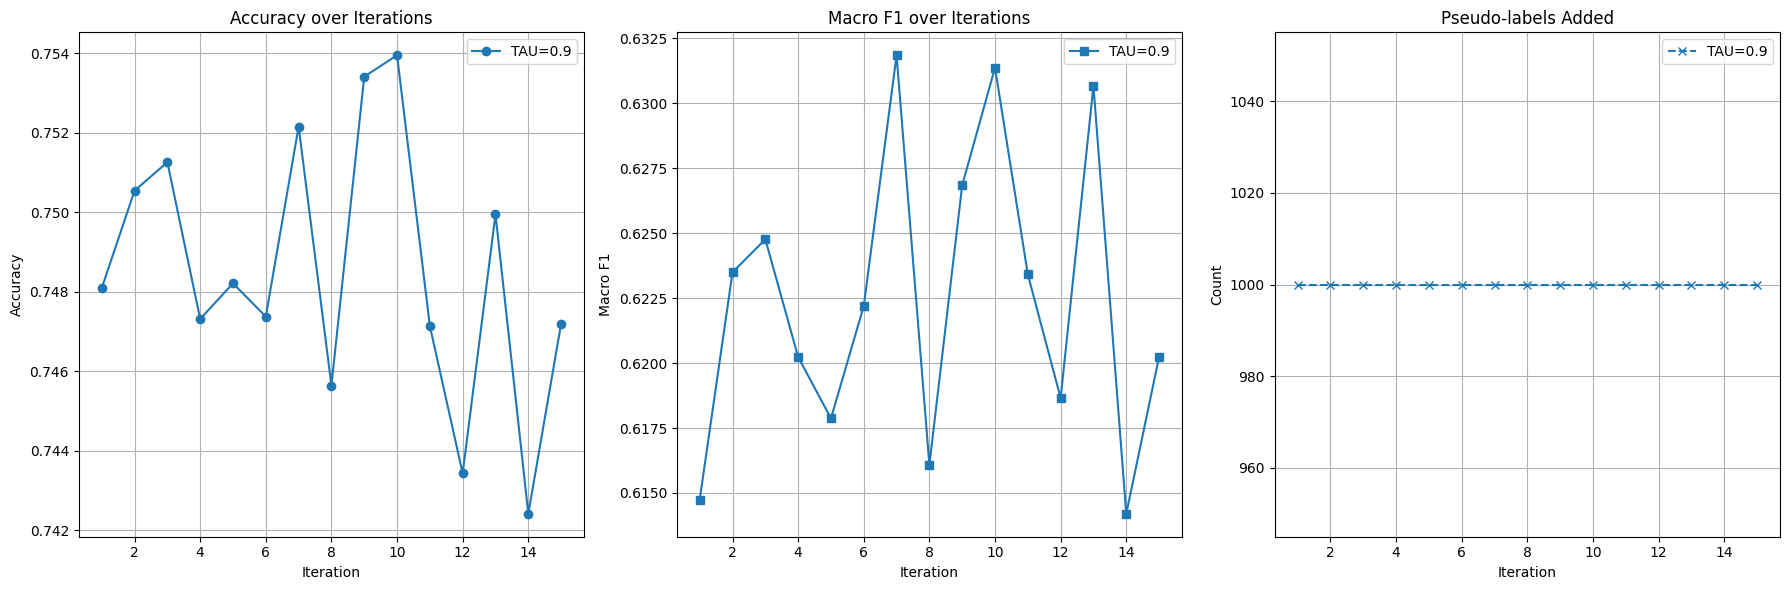

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

# ===================== CONFIG =====================
TAU_VALUES = [0.90]
MAX_ITER = 15
MAX_ADD = 1000
CUTOFF = "2017-01-01"

PROJECT_ROOT = (
    Path('.').resolve().parent
    if Path('.').resolve().name == 'notebooks'
    else Path('.').resolve()
)

DATA_PATH = PROJECT_ROOT / "data" / "processed" / "dataset_for_semi.parquet"

# ===================== DATA =====================
def load_and_prep_data():
    df = pd.read_parquet(DATA_PATH)

    # Time column
    time_col = next((c for c in ['datetime', 'date'] if c in df.columns), None)
    if time_col:
        df['date'] = pd.to_datetime(df[time_col])
    else:
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

    # Target
    df = df.dropna(subset=['PM2.5'])
    df['aqi_class'] = pd.cut(
        df['PM2.5'],
        bins=[-1, 35, 75, 115, 150, 250, 9999],
        labels=[0, 1, 2, 3, 4, 5]
    ).astype(int)

    # Feature selection
    exclude = [
        'date', 'datetime', 'station', 'year', 'month', 'day',
        'aqi_class', 'PM2.5', 'No', 'pm25_24h', 'PM10',
        'is_labeled', 'pm25_lag_1', 'pm25_lag_2'
    ]
    features = [c for c in df.columns if c not in exclude]

    # Encode categorical
    le = LabelEncoder()
    for col in features:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col].astype(str))

    # Split by time
    split_date = pd.to_datetime(CUTOFF)
    df_test = df[df['date'] >= split_date].copy()
    df_pool = df[df['date'] < split_date].copy()

    # Labeled / Unlabeled
    if 'is_labeled' in df_pool.columns:
        df_L = df_pool[df_pool['is_labeled'] == True].copy()
        df_U = df_pool[df_pool['is_labeled'] == False].copy()
    else:
        df_L = df_pool.sample(frac=0.02, random_state=42)
        df_U = df_pool.drop(df_L.index)

    return df_L, df_U, df_test, features

# ===================== SELF-TRAINING =====================
def run_experiment(tau):
    print(f"\n>> Running TAU={tau}")

    df_L, df_U, df_test, feats = load_and_prep_data()

    clf = RandomForestClassifier(
        n_estimators=50,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    history_f1 = []
    history_acc = []
    history_added = []

    for i in range(MAX_ITER):
        # Train
        clf.fit(df_L[feats], df_L['aqi_class'])

        # Evaluate on test
        y_pred = clf.predict(df_test[feats])
        f1 = f1_score(df_test['aqi_class'], y_pred, average='macro')
        acc = accuracy_score(df_test['aqi_class'], y_pred)

        history_f1.append(f1)
        history_acc.append(acc)

        # Stop if no unlabeled left
        if len(df_U) == 0:
            break

        # Pseudo-labeling
        probs = clf.predict_proba(df_U[feats])
        max_probs = probs.max(axis=1)
        high_conf_idx = np.where(max_probs > tau)[0]

        if len(high_conf_idx) > MAX_ADD:
            high_conf_idx = np.random.choice(high_conf_idx, MAX_ADD, replace=False)

        num_added = len(high_conf_idx)
        history_added.append(num_added)

        print(
            f"   Iter {i+1}: "
            f"Acc={acc:.4f} | F1={f1:.4f} | Added={num_added}"
        )

        if num_added == 0:
            break

        # Add pseudo-labeled samples
        df_new = df_U.iloc[high_conf_idx].copy()
        df_new['aqi_class'] = clf.predict(df_new[feats])

        df_L = pd.concat([df_L, df_new])
        df_U = df_U.drop(df_new.index)

    print(
        f"\nFinal model (TAU={tau}): "
        f"Accuracy={history_acc[-1]:.4f}, "
        f"Macro F1={history_f1[-1]:.4f}"
    )

    return history_acc, history_f1, history_added

# ===================== RUN =====================
results = {}
for tau in TAU_VALUES:
    results[tau] = run_experiment(tau)

# ===================== PLOT =====================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

for tau in TAU_VALUES:
    acc, f1, added = results[tau]
    iters = range(1, len(acc) + 1)

    ax1.plot(iters, acc, marker='o', label=f'TAU={tau}')
    ax2.plot(iters, f1, marker='s', label=f'TAU={tau}')
    ax3.plot(iters, added, marker='x', linestyle='--', label=f'TAU={tau}')

ax1.set_title('Accuracy over Iterations')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()

ax2.set_title('Macro F1 over Iterations')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Macro F1')
ax2.grid(True)
ax2.legend()

ax3.set_title('Pseudo-labels Added')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Count')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()
